ADVANCED CRYPTO RELATIVE VALUE STRATEGY RESEARCH
Configuration:
   Symbols: ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD']
   Lookback: 30 days (8640 bars)
   Forward periods: [12, 24, 48, 96, 288] bars
   Signal thresholds: {'extreme': 2.0, 'strong': 1.5, 'moderate': 1.0, 'weak': 0.5}

STEP 1: Loading cryptocurrency data...
Loading symbol 1/4: BTCUSD
Loading data for BTCUSD...
Found 10 files for BTCUSD
Loading file 1/10: BTCUSD_5m_2016.csv
Loading file 6/10: BTCUSD_5m_2021.csv
Concatenating 10 dataframes for BTCUSD...
Loaded BTCUSD: 276,377 records from 2023-01-01 00:00:00 to 2025-08-17 15:20:00
✓ Successfully loaded BTCUSD
Loading symbol 2/4: ETHUSD
Loading data for ETHUSD...
Found 10 files for ETHUSD
Loading file 1/10: ETHUSD_5m_2016.csv
Loading file 6/10: ETHUSD_5m_2021.csv
Concatenating 10 dataframes for ETHUSD...
Loaded ETHUSD: 276,378 records from 2023-01-01 00:00:00 to 2025-08-17 15:25:00
✓ Successfully loaded ETHUSD
Loading symbol 3/4: SOLUSD
Loading data for SOLUSD...
Found 5 files

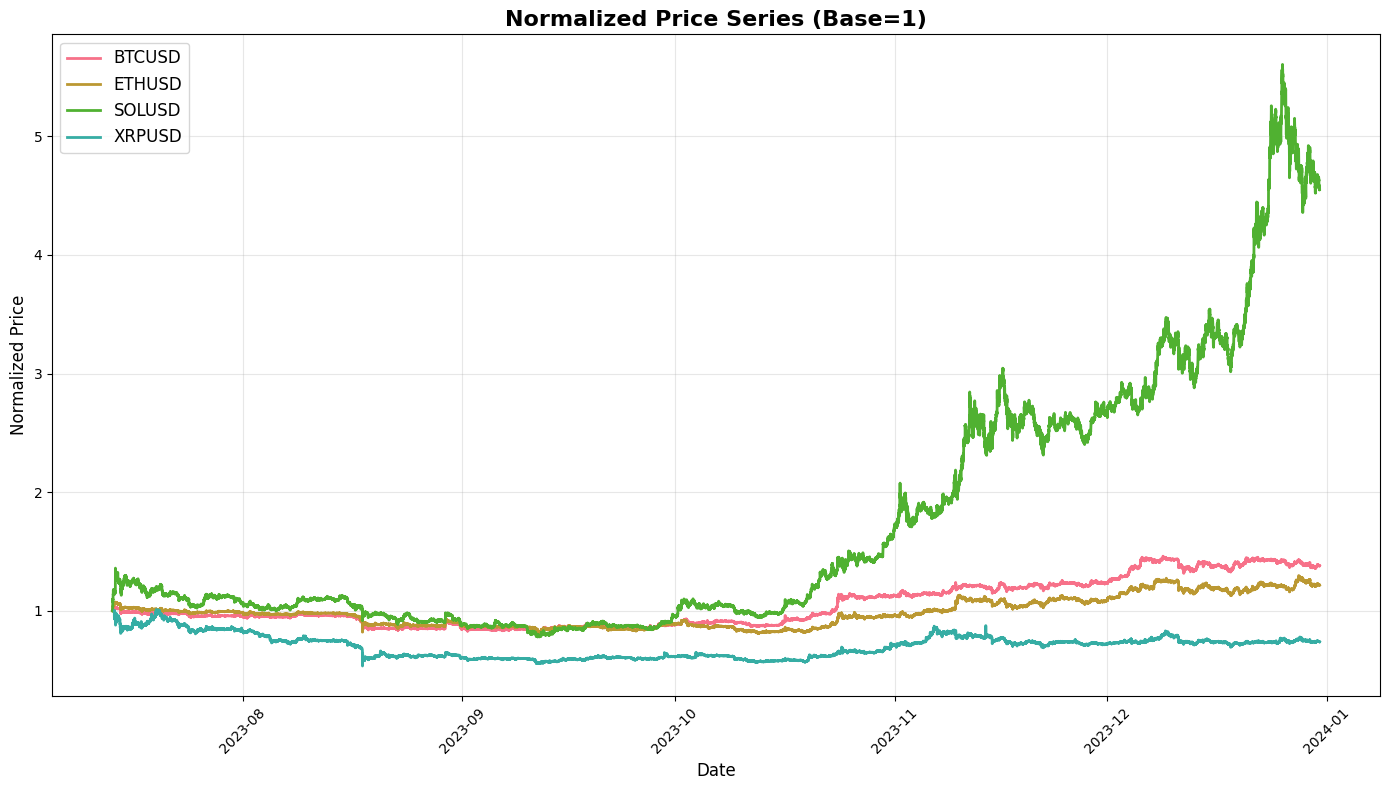

Calculating and plotting correlation matrix...


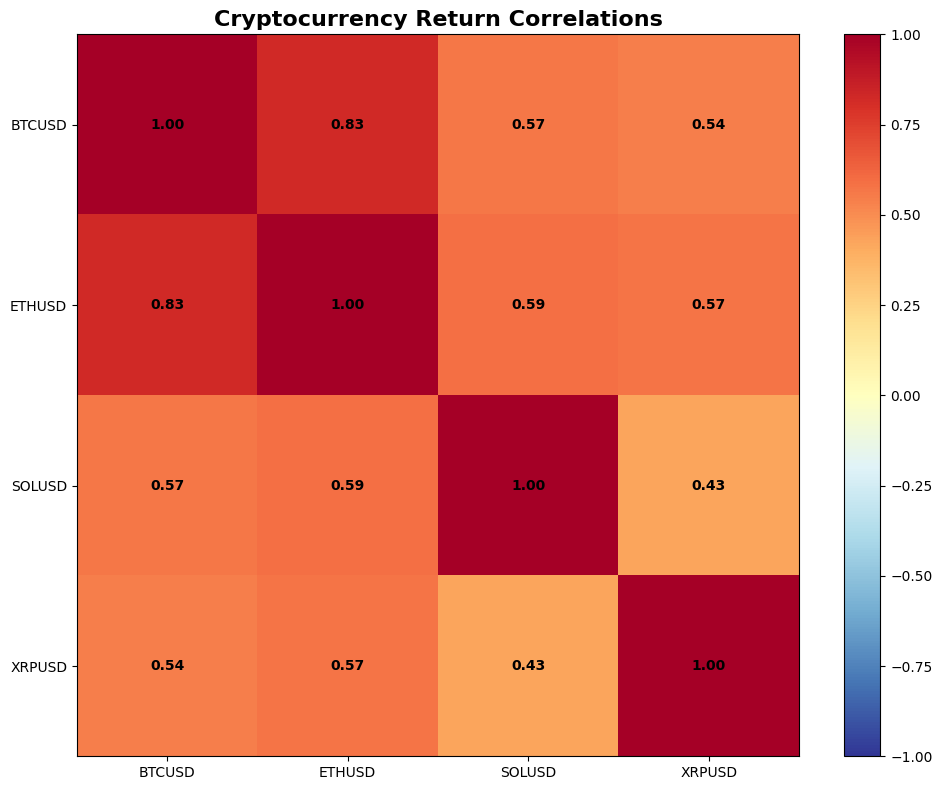

Plotting rolling statistics with 288 period window...


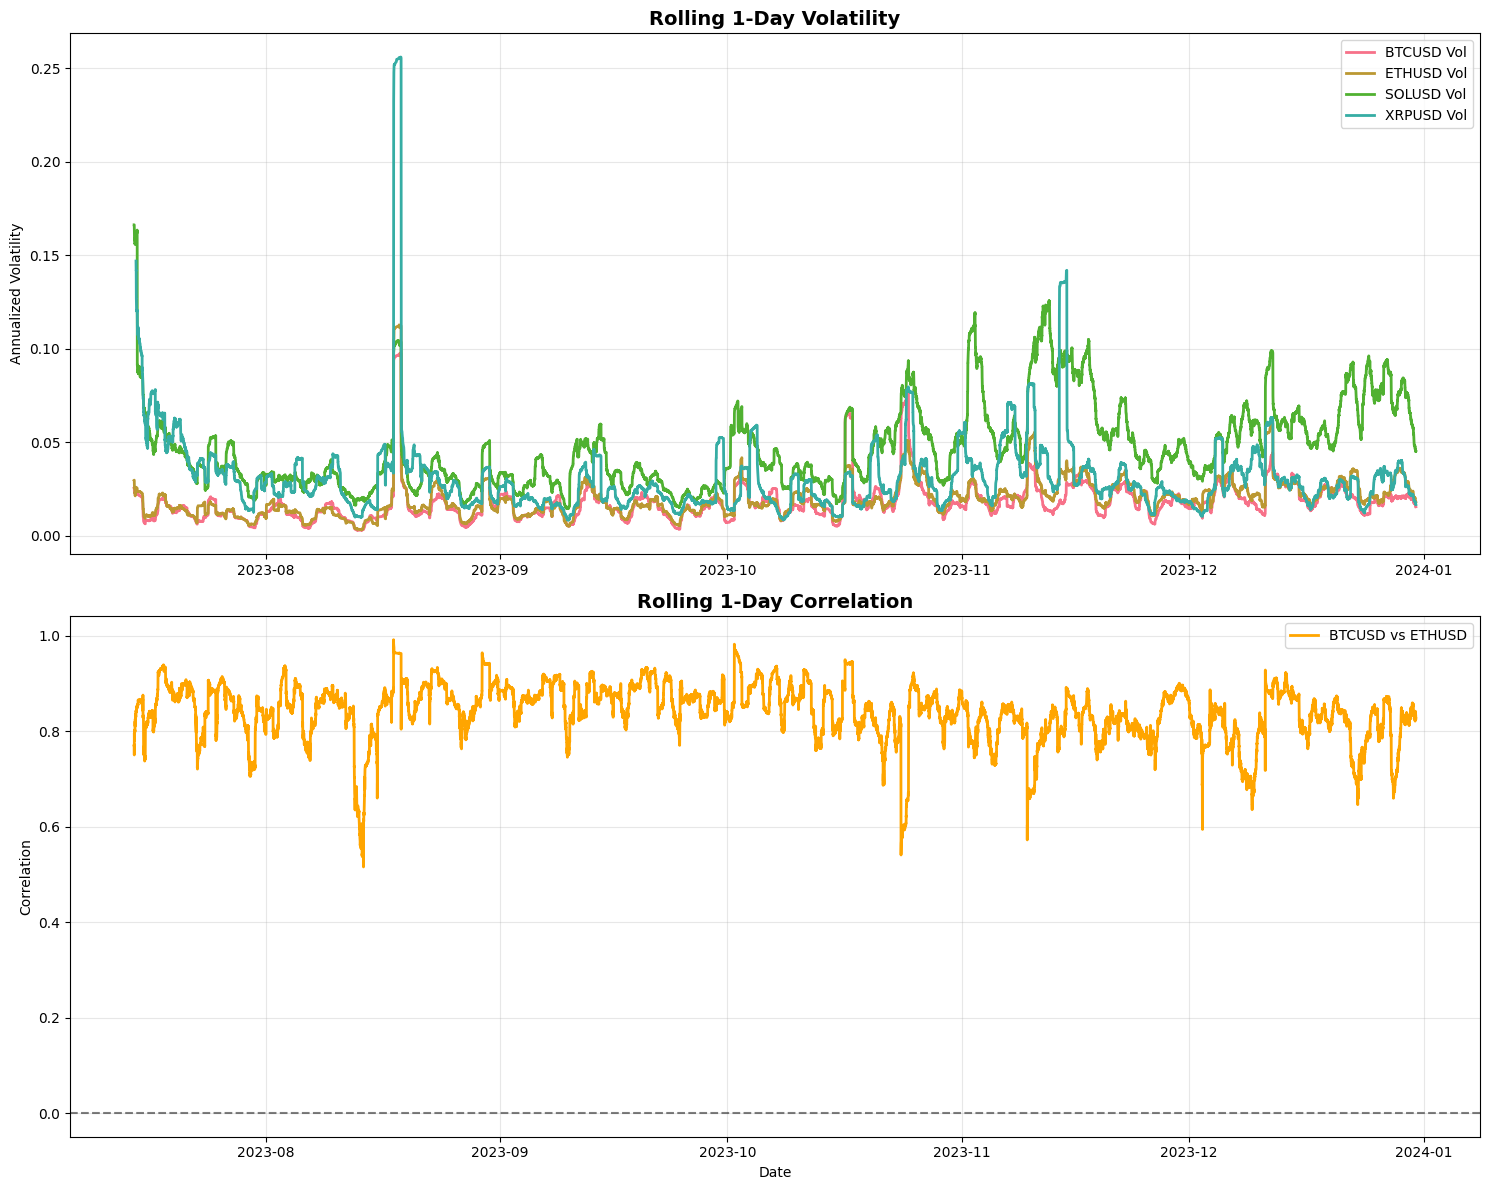


STEP 5: Feature engineering...
Processing training data...
Calculating ratio spreads for 4 symbols...
Processing 6 pairs...
Processing pair 1/6: BTCUSD-ETHUSD
Processing pair 2/6: BTCUSD-SOLUSD
Processing pair 3/6: BTCUSD-XRPUSD
Processing pair 4/6: ETHUSD-SOLUSD
Processing pair 5/6: ETHUSD-XRPUSD
Processing pair 6/6: SOLUSD-XRPUSD
Added ratio spreads. Dataset now has 24 columns
Calculating rolling features...
Processing symbol 1/4: BTCUSD
Processing symbol 2/4: ETHUSD
Processing symbol 3/4: SOLUSD
Processing symbol 4/4: XRPUSD
Calculating z-scores for spreads...
Processing spread 1/18: log_ratio_BTCUSD_ETHUSD
Processing spread 6/18: normalized_ratio_BTCUSD_SOLUSD
Processing spread 11/18: simple_ratio_ETHUSD_SOLUSD
Processing spread 16/18: log_ratio_SOLUSD_XRPUSD
Rolling features complete. Dataset now has 58 columns
Processing test data...
Calculating ratio spreads for 4 symbols...
Processing 6 pairs...
Processing pair 1/6: BTCUSD-ETHUSD
Processing pair 2/6: BTCUSD-SOLUSD
Processing p

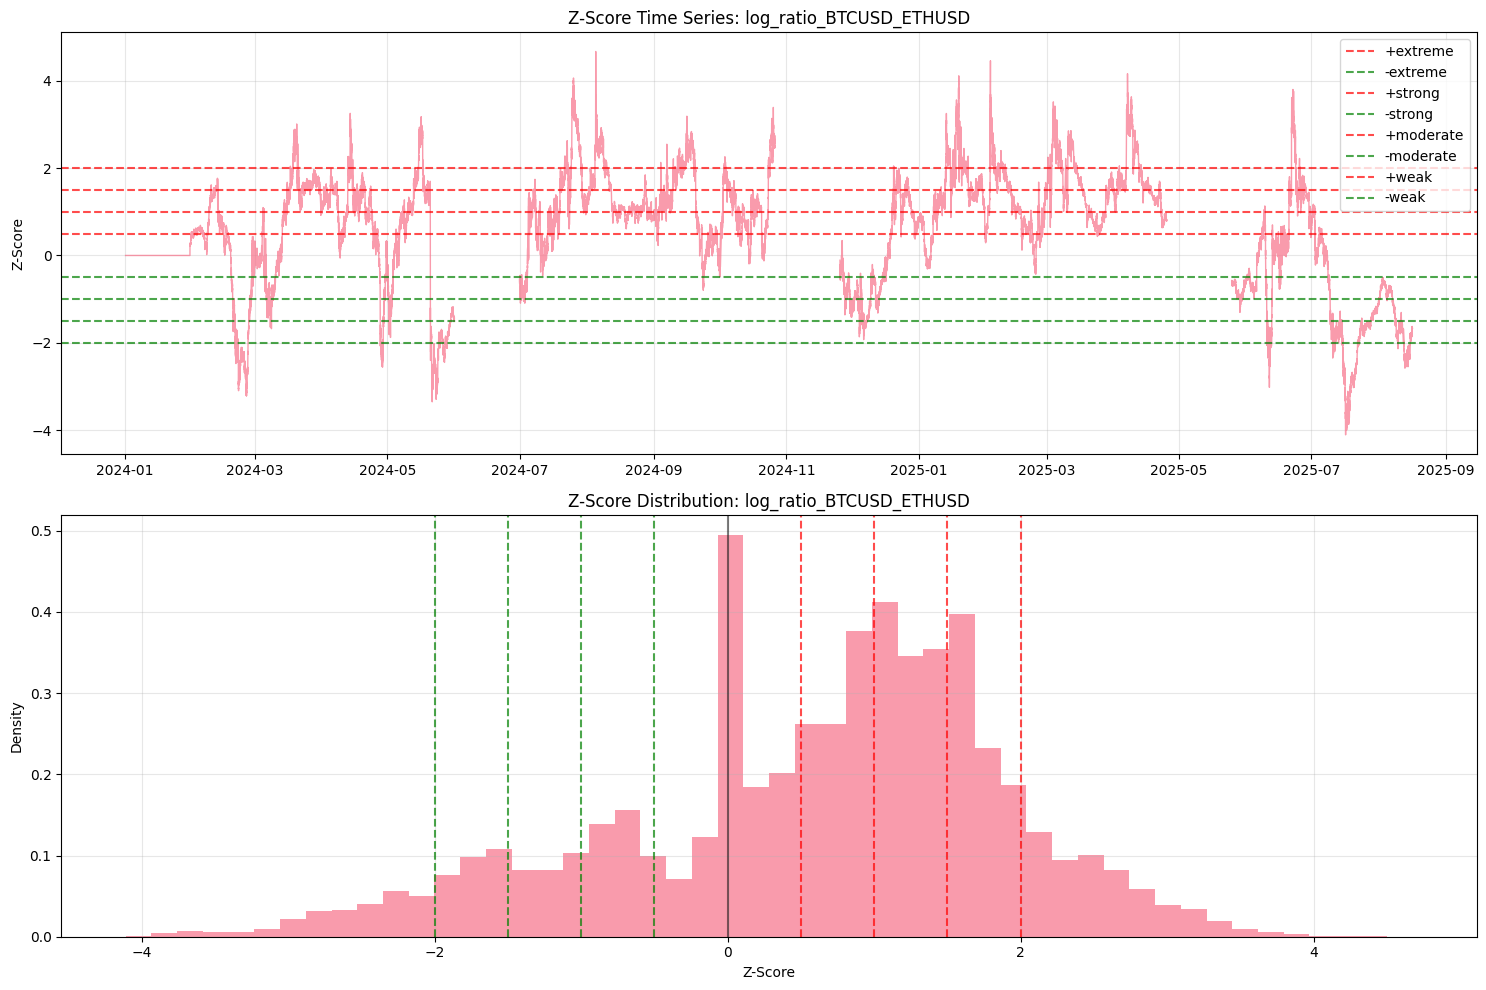


STEP 7: Running backtests on test data...
Running backtests for up to 8 strategies...
Found 8 spreads to backtest
Backtesting spread 1/8: log_ratio_BTCUSD_ETHUSD
Backtesting log_ratio_BTCUSD_ETHUSD with threshold 2.0
  extreme: Return=-20.8826, Trades=1020, WinRate=0.43
Backtesting log_ratio_BTCUSD_ETHUSD with threshold 1.5
  strong: Return=-22.5924, Trades=3681, WinRate=0.46
Backtesting log_ratio_BTCUSD_ETHUSD with threshold 1.0
  moderate: Return=-41.6740, Trades=13812, WinRate=0.47
Backtesting log_ratio_BTCUSD_ETHUSD with threshold 0.5
  weak: Return=-92.9868, Trades=43079, WinRate=0.45
Backtesting spread 2/8: simple_ratio_BTCUSD_ETHUSD
Backtesting simple_ratio_BTCUSD_ETHUSD with threshold 2.0
  extreme: Return=-21.8061, Trades=1087, WinRate=0.43
Backtesting simple_ratio_BTCUSD_ETHUSD with threshold 1.5
  strong: Return=-24.8721, Trades=3887, WinRate=0.46
Backtesting simple_ratio_BTCUSD_ETHUSD with threshold 1.0
  moderate: Return=-43.8942, Trades=14189, WinRate=0.47
Backtesting si

In [ ]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import glob
from pathlib import Path
import warnings
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import statsmodels.api as sm
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from datetime import datetime
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import os

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# =============================================================================
# CONFIGURATION
# =============================================================================

class Config:
    # Data parameters
    FREQ_MINUTES = 5
    BARS_PER_DAY = 288  # 24 * 60 // FREQ_MINUTES # 288 bars per day
    
    # Rolling window parameters
    LOOKBACK_DAYS = 30
    LOOKBACK_BARS = LOOKBACK_DAYS * BARS_PER_DAY
    
    # Forward return parameters
    FORWARD_RETURN_PERIODS = [12, 24, 48, 96, 288]  # 1h, 2h, 4h, 8h, 24h
    
    # Signal parameters
    SIGNAL_THRESHOLDS = {
        'extreme': 2.0,
        'strong': 1.5,
        'moderate': 1.0,
        'weak': 0.5
    }
    
    # Ratio spread parameters
    SPREAD_TYPES = ['log_ratio', 'simple_ratio', 'normalized_ratio']
    
    # Symbols to analyze
    SYMBOLS = ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD']
    
    # Analysis parameters
    MIN_OBSERVATIONS = 100
    CONFIDENCE_LEVEL = 0.95
    
    # Backtesting parameters
    INITIAL_CASH = 100000
    COMMISSION = 0.001  # 0.1% commission
    STAKE = 0.1  # 10% of portfolio per trade
    
    # Train-test split
    TRAIN_END_DATE = '2023-12-31'
    TEST_START_DATE = '2024-01-01'
    
    # Performance parameters
    MAX_WORKERS = 4  # Added missing parameter
    CHUNK_SIZE = 10000  # Process data in chunks to avoid memory issues

config = Config()

# =============================================================================
# DATA LOADING & PREPROCESSING
# =============================================================================

def load_crypto_data_polars(symbol: str, data_dir: str = "coinbase/5m") -> Optional[pl.DataFrame]:
    """Load crypto data using Polars for faster processing"""
    print(f"Loading data for {symbol}...")
    
    try:
        files = sorted(glob.glob(f"{data_dir}/*/{symbol}_5m_*.csv"))
        if not files:
            print(f"No files found for {symbol} in {data_dir}")
            return None
        
        print(f"Found {len(files)} files for {symbol}")
        
        # Define schema for faster parsing
        schema = {
            'time': pl.Int64,
            'open': pl.Float64,
            'high': pl.Float64,
            'low': pl.Float64,
            'close': pl.Float64,
            'volume': pl.Float64
        }
        
        # Load files sequentially without nested progress bars
        dfs = []
        for i, file in enumerate(files):
            if i % 5 == 0:  # Print progress every 5 files
                print(f"Loading file {i+1}/{len(files)}: {os.path.basename(file)}")
            
            try:
                df = pl.read_csv(
                    file,
                    has_header=False,
                    new_columns=list(schema.keys()),
                    schema=schema,
                    try_parse_dates=False
                )
                if not df.is_empty():
                    dfs.append(df)
            except Exception as e:
                print(f"Error loading {file}: {e}")
                continue
        
        if not dfs:
            print(f"No valid data found for {symbol}")
            return None
        
        print(f"Concatenating {len(dfs)} dataframes for {symbol}...")
        combined = pl.concat(dfs, how="vertical")
        
        # Clean and prepare data
        result = (combined
                     .filter(pl.col('time').is_not_null() & pl.col('close').is_not_null())
                     .with_columns([
                         pl.from_epoch(pl.col('time'), time_unit='s').alias('datetime'),
                         pl.col('close').alias(f'close_{symbol.lower()}')
                     ])
                     .filter(pl.col('datetime').dt.year() >= 2023)
                     .sort('time')
                     .unique('time', keep='first')
                     )
        
        print(f"Loaded {symbol}: {result.height:,} records from {result['datetime'].min()} to {result['datetime'].max()}")
        return result
        
    except Exception as e:
        print(f"Error loading {symbol}: {e}")
        return None

def create_time_aligned_data(symbol_data: Dict[str, pl.DataFrame]) -> pl.DataFrame:
    """Create time-aligned dataset with all symbols"""
    if not symbol_data:
        raise ValueError("No symbol data provided")
    
    print("Creating time-aligned dataset...")
    
    # Find common time range
    min_time = max(df['time'].min() for df in symbol_data.values())
    max_time = min(df['time'].max() for df in symbol_data.values())
    
    print(f"Common time range: {min_time} to {max_time}")
    
    # Start with the first symbol's data as base
    first_symbol = list(symbol_data.keys())[0]
    result = symbol_data[first_symbol].select(['time', 'datetime', f'close_{first_symbol.lower()}'])
    
    # Join other symbols one by one
    for symbol in list(symbol_data.keys())[1:]:
        print(f"Joining {symbol}...")
        symbol_df = symbol_data[symbol].select(['time', f'close_{symbol.lower()}'])
        result = result.join(symbol_df, on='time', how='inner')  # Use inner join for clean data
    
    # Clean and sort
    result = (result
              .filter(pl.col('time') >= min_time)
              .filter(pl.col('time') <= max_time)
              .sort('time')
              .drop_nulls()
              )
    
    print(f"Time-aligned dataset: {result.height:,} records")
    return result

# =============================================================================
# EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================

class CryptoEDA:
    """Class for performing exploratory data analysis on crypto data"""
    
    def __init__(self, df: pl.DataFrame, symbols: List[str]):
        self.df = df
        self.symbols = symbols
        print(f"EDA initialized with {df.height} records and {len(symbols)} symbols")
    
    def plot_price_series(self):
        """Plot normalized price series for all symbols"""
        print("Plotting normalized price series...")
        
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Convert to pandas for easier plotting
        df_pd = self.df.select(['datetime'] + [f'close_{sym.lower()}' for sym in self.symbols]).to_pandas()
        
        # Normalize prices to starting value of 1
        for symbol in self.symbols:
            col = f'close_{symbol.lower()}'
            if col in df_pd.columns and len(df_pd[col].dropna()) > 0:
                first_price = df_pd[col].dropna().iloc[0]
                normalized_prices = df_pd[col] / first_price
                ax.plot(df_pd['datetime'], normalized_prices, label=symbol, linewidth=2)
        
        ax.set_title('Normalized Price Series (Base=1)', fontsize=16, fontweight='bold')
        ax.set_ylabel('Normalized Price', fontsize=12)
        ax.set_xlabel('Date', fontsize=12)
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def plot_correlation_matrix(self):
        """Plot correlation matrix of returns"""
        print("Calculating and plotting correlation matrix...")
        
        # Convert to pandas for easier calculation
        df_pd = self.df.to_pandas()
        
        # Calculate returns
        returns_data = {}
        for symbol in self.symbols:
            col = f'close_{symbol.lower()}'
            if col in df_pd.columns:
                returns = df_pd[col].pct_change().fillna(0)
                returns_data[symbol] = returns
        
        if not returns_data:
            print("No return data available for correlation matrix")
            return
        
        # Create correlation matrix using pandas
        returns_df = pd.DataFrame(returns_data)
        corr_matrix = returns_df.corr().values
        
        # Plot heatmap
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(corr_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1)
        
        # Add labels
        ax.set_xticks(np.arange(len(self.symbols)))
        ax.set_yticks(np.arange(len(self.symbols)))
        ax.set_xticklabels(self.symbols)
        ax.set_yticklabels(self.symbols)
        
        # Add values to cells
        for i in range(len(self.symbols)):
            for j in range(len(self.symbols)):
                if not np.isnan(corr_matrix[i, j]):
                    text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                                  ha="center", va="center", color="black", fontweight='bold')
        
        ax.set_title('Cryptocurrency Return Correlations', fontsize=16, fontweight='bold')
        fig.colorbar(im, ax=ax)
        plt.tight_layout()
        plt.show()
    
    def plot_rolling_statistics(self, window: int = 288):
        """Plot rolling statistics (volatility and correlation)"""
        print(f"Plotting rolling statistics with {window} period window...")
        
        df_pd = self.df.to_pandas()
        
        # Plot rolling volatility
        fig, axes = plt.subplots(2, 1, figsize=(15, 12))
        
        # Rolling volatility
        for symbol in self.symbols:
            col = f'close_{symbol.lower()}'
            if col in df_pd.columns:
                returns = df_pd[col].pct_change()
                rolling_vol = returns.rolling(window=window).std() * np.sqrt(config.BARS_PER_DAY)
                axes[0].plot(df_pd['datetime'], rolling_vol, label=f'{symbol} Vol', linewidth=2)
        
        axes[0].set_title(f'Rolling {window//config.BARS_PER_DAY}-Day Volatility', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Annualized Volatility')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Rolling correlation (first pair)
        if len(self.symbols) >= 2:
            col1 = f'close_{self.symbols[0].lower()}'
            col2 = f'close_{self.symbols[1].lower()}'
            
            if col1 in df_pd.columns and col2 in df_pd.columns:
                ret1 = df_pd[col1].pct_change()
                ret2 = df_pd[col2].pct_change()
                rolling_corr = ret1.rolling(window=window).corr(ret2)
                
                axes[1].plot(df_pd['datetime'], rolling_corr, label=f'{self.symbols[0]} vs {self.symbols[1]}', 
                            linewidth=2, color='orange')
                axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
                axes[1].set_title(f'Rolling {window//config.BARS_PER_DAY}-Day Correlation', fontsize=14, fontweight='bold')
                axes[1].set_ylabel('Correlation')
                axes[1].set_xlabel('Date')
                axes[1].legend()
                axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def generate_summary_statistics(self) -> pl.DataFrame:
        """Generate summary statistics for all symbols"""
        print("Generating summary statistics...")
        
        df_pd = self.df.to_pandas()
        stats_list = []
        
        for symbol in self.symbols:
            col = f'close_{symbol.lower()}'
            if col in df_pd.columns:
                prices = df_pd[col].dropna()
                if len(prices) > 0:
                    returns = prices.pct_change().fillna(0)
                    
                    # Calculate Sharpe ratio
                    if returns.std() > 0:
                        sharpe = (returns.mean() / returns.std()) * np.sqrt(config.BARS_PER_DAY)
                    else:
                        sharpe = 0
                    
                    stats_list.append({
                        'Symbol': symbol,
                        'Start Date': str(df_pd['datetime'].min().date()),
                        'End Date': str(df_pd['datetime'].max().date()),
                        'Total Observations': len(prices),
                        'Mean Price': round(prices.mean(), 4),
                        'Price Std': round(prices.std(), 4),
                        'Daily Return (%)': round(returns.mean() * config.BARS_PER_DAY * 100, 4),
                        'Daily Volatility (%)': round(returns.std() * np.sqrt(config.BARS_PER_DAY) * 100, 4),
                        'Sharpe Ratio': round(sharpe, 4),
                        'Max Drawdown (%)': round(self.calculate_max_drawdown(prices) * 100, 4)
                    })
        
        return pl.DataFrame(stats_list)
    
    def calculate_max_drawdown(self, prices: pd.Series) -> float:
        """Calculate maximum drawdown for a price series"""
        if len(prices) == 0:
            return 0.0
        cumulative_max = prices.cummax()
        drawdown = (prices - cumulative_max) / cumulative_max
        return drawdown.min()

# =============================================================================
# FEATURE ENGINEERING
# =============================================================================

def calculate_ratio_spreads(df: pl.DataFrame, symbols: List[str]) -> pl.DataFrame:
    """Calculate ratio-based spreads between all symbol pairs"""
    
    print(f"Calculating ratio spreads for {len(symbols)} symbols...")
    result = df.clone()
    
    pairs = list(combinations(symbols, 2))
    print(f"Processing {len(pairs)} pairs...")
    
    for i, (sym1, sym2) in enumerate(pairs):
        print(f"Processing pair {i+1}/{len(pairs)}: {sym1}-{sym2}")
        
        col1 = f'close_{sym1.lower()}'
        col2 = f'close_{sym2.lower()}'
        pair_name = f"{sym1}_{sym2}"
        
        # Check if columns exist
        if col1 not in result.columns or col2 not in result.columns:
            print(f"Warning: Missing columns for {pair_name}")
            continue
        
        try:
            # Log ratio (most stable for financial data)
            log_ratio = (pl.col(col1) / pl.col(col2)).log()
            
            # Simple ratio
            simple_ratio = pl.col(col1) / pl.col(col2)
            
            # Normalized ratio (subtract 1 for mean-reverting signals)
            normalized_ratio = (pl.col(col1) / pl.col(col2)) - 1.0
            
            result = result.with_columns([
                log_ratio.alias(f'log_ratio_{pair_name}'),
                simple_ratio.alias(f'simple_ratio_{pair_name}'),  
                normalized_ratio.alias(f'normalized_ratio_{pair_name}')
            ])
            
        except Exception as e:
            print(f"Error calculating ratios for {pair_name}: {e}")
            continue
    
    print(f"Added ratio spreads. Dataset now has {len(result.columns)} columns")
    return result

def calculate_rolling_features(df: pl.DataFrame, symbols: List[str]) -> pl.DataFrame:
    """Calculate rolling features for all symbols and spreads"""
    
    print("Calculating rolling features...")
    result = df.clone()
    
    # Calculate features for individual symbols
    for i, symbol in enumerate(symbols):
        print(f"Processing symbol {i+1}/{len(symbols)}: {symbol}")
        col = f'close_{symbol.lower()}'
        
        if col not in result.columns:
            print(f"Warning: Column {col} not found")
            continue
        
        try:
            # Rolling returns for different periods
            for period in [12, 24, 48]:  # 1h, 2h, 4h returns
                ret_col = (pl.col(col) / pl.col(col).shift(period) - 1).alias(f'ret_{period}_{symbol.lower()}')
                result = result.with_columns([ret_col])
            
            # Rolling volatility (8h window)
            vol_col = pl.col(col).pct_change().rolling_std(window_size=96).alias(f'vol_96_{symbol.lower()}')
            result = result.with_columns([vol_col])
            
        except Exception as e:
            print(f"Error calculating features for {symbol}: {e}")
            continue
    
    # Calculate z-scores for spread columns
    print("Calculating z-scores for spreads...")
    spread_cols = [col for col in result.columns if any(st in col for st in config.SPREAD_TYPES)]
    
    for i, spread_col in enumerate(spread_cols):
        if i % 5 == 0:  # Print progress every 5 spreads
            print(f"Processing spread {i+1}/{len(spread_cols)}: {spread_col}")
        
        try:
            # Rolling z-score
            rolling_mean = pl.col(spread_col).rolling_mean(window_size=config.LOOKBACK_BARS)
            rolling_std = pl.col(spread_col).rolling_std(window_size=config.LOOKBACK_BARS)
            zscore = pl.when(rolling_std > 1e-8).then(
                (pl.col(spread_col) - rolling_mean) / rolling_std
            ).otherwise(0.0)
            
            result = result.with_columns([zscore.alias(f'zscore_{spread_col}')])
            
        except Exception as e:
            print(f"Error calculating z-score for {spread_col}: {e}")
            continue
    
    print(f"Rolling features complete. Dataset now has {len(result.columns)} columns")
    return result

def split_train_test_data(df: pl.DataFrame) -> Tuple[pl.DataFrame, pl.DataFrame]:
    """Split data into train and test sets without data leakage"""
    print("Splitting data into train and test sets...")
    
    train_df = df.filter(pl.col('datetime') < datetime.strptime(config.TRAIN_END_DATE, "%Y-%m-%d"))
    test_df = df.filter(pl.col('datetime') >= datetime.strptime(config.TEST_START_DATE, "%Y-%m-%d"))
    
    print(f"Train set: {train_df.height:,} records ({train_df['datetime'].min()} to {train_df['datetime'].max()})")
    print(f"Test set: {test_df.height:,} records ({test_df['datetime'].min()} to {test_df['datetime'].max()})")
    
    return train_df, test_df

def calculate_forward_returns_safe(df: pl.DataFrame, symbols: List[str], periods: List[int]) -> pl.DataFrame:
    """Calculate forward returns safely without data leakage"""
    print(f"Calculating forward returns for periods: {periods}")
    
    result = df.clone()
    
    # Only calculate forward returns for symbols (not spreads to avoid data leakage in spreads)
    for symbol in symbols:
        col = f'close_{symbol.lower()}'
        if col not in result.columns:
            continue
            
        for period in periods:
            try:
                # Price return
                price_ret = (pl.col(col).shift(-period) / pl.col(col) - 1.0)
                result = result.with_columns([price_ret.alias(f'fut_ret_{period}_{symbol.lower()}')])
            except Exception as e:
                print(f"Error calculating forward return for {symbol} period {period}: {e}")
                continue
    
    return result

# =============================================================================
# SIGNAL ANALYSIS AND REGRESSION
# =============================================================================

class SignalAnalyzer:
    """Class for analyzing signals and running regressions"""
    
    def __init__(self, train_df: pl.DataFrame, test_df: pl.DataFrame, symbols: List[str]):
        self.train_df = train_df
        self.test_df = test_df
        self.symbols = symbols
        self.results = {}
    
    def analyze_spread_predictability(self, target_period: int = 24) -> Dict[str, Any]:
        """Analyze predictability of different spreads"""
        print(f"Analyzing spread predictability for {target_period} period forward returns...")
        
        # Get z-score columns
        zscore_cols = [col for col in self.train_df.columns if col.startswith('zscore_')]
        target_cols = [col for col in self.train_df.columns if f'fut_ret_{target_period}_' in col]
        
        print(f"Found {len(zscore_cols)} z-score features and {len(target_cols)} targets")
        
        results = {}
        
        for target_col in target_cols:
            print(f"Analyzing target: {target_col}")
            
            # Convert to pandas for sklearn
            train_data = self.train_df.select(zscore_cols + [target_col]).to_pandas().dropna()
            
            if len(train_data) < config.MIN_OBSERVATIONS:
                print(f"Insufficient data for {target_col}")
                continue
            
            X_train = train_data[zscore_cols].values
            y_train = train_data[target_col].values
            
            # Fit linear regression
            model = LinearRegression()
            model.fit(X_train, y_train)
            
            # Calculate in-sample metrics
            y_pred_train = model.predict(X_train)
            r2_train = r2_score(y_train, y_pred_train)
            mse_train = mean_squared_error(y_train, y_pred_train)
            
            # Out-of-sample prediction on test set
            test_data = self.test_df.select(zscore_cols + [target_col]).to_pandas().dropna()
            if len(test_data) > 0:
                X_test = test_data[zscore_cols].values
                y_test = test_data[target_col].values
                y_pred_test = model.predict(X_test)
                
                r2_test = r2_score(y_test, y_pred_test)
                mse_test = mean_squared_error(y_test, y_pred_test)
            else:
                r2_test = np.nan
                mse_test = np.nan
            
            # Store results
            results[target_col] = {
                'r2_train': r2_train,
                'mse_train': mse_train,
                'r2_test': r2_test,
                'mse_test': mse_test,
                'model': model,
                'feature_importance': dict(zip(zscore_cols, model.coef_))
            }
            
            print(f"  R² Train: {r2_train:.4f}, R² Test: {r2_test:.4f}")
        
        self.results['predictability'] = results
        return results
    
    def generate_trading_signals(self, threshold_dict: Dict[str, float]) -> pl.DataFrame:
        """Generate trading signals based on z-scores and thresholds"""
        print("Generating trading signals...")
        
        result = self.test_df.clone()
        
        # Get z-score columns
        zscore_cols = [col for col in result.columns if col.startswith('zscore_')]
        
        for zscore_col in zscore_cols:
            spread_name = zscore_col.replace('zscore_', '')
            
            for threshold_name, threshold_value in threshold_dict.items():
                # Long signal when z-score < -threshold (spread is low)
                # Short signal when z-score > threshold (spread is high)
                
                long_signal = (pl.col(zscore_col) < -threshold_value).cast(pl.Int32)
                short_signal = (pl.col(zscore_col) > threshold_value).cast(pl.Int32)
                combined_signal = short_signal - long_signal  # -1 for long, +1 for short, 0 for neutral
                
                result = result.with_columns([
                    long_signal.alias(f'long_{threshold_name}_{spread_name}'),
                    short_signal.alias(f'short_{threshold_name}_{spread_name}'),
                    combined_signal.alias(f'signal_{threshold_name}_{spread_name}')
                ])
        
        print(f"Generated signals. Dataset now has {len(result.columns)} columns")
        return result
    
    def plot_signal_analysis(self, spread_name: str = None):
        """Plot signal analysis for a specific spread"""
        if spread_name is None:
            # Use first available spread
            zscore_cols = [col for col in self.test_df.columns if col.startswith('zscore_')]
            if not zscore_cols:
                print("No z-score columns found")
                return
            spread_name = zscore_cols[0].replace('zscore_', '')
        
        zscore_col = f'zscore_{spread_name}'
        if zscore_col not in self.test_df.columns:
            print(f"Z-score column {zscore_col} not found")
            return
        
        print(f"Plotting signal analysis for {spread_name}")
        
        # Convert to pandas for plotting
        plot_data = self.test_df.select(['datetime', zscore_col]).to_pandas()
        
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        
        # Plot z-score time series
        axes[0].plot(plot_data['datetime'], plot_data[zscore_col], linewidth=1, alpha=0.7)
        
        # Add threshold lines
        for threshold_name, threshold_value in config.SIGNAL_THRESHOLDS.items():
            axes[0].axhline(y=threshold_value, color='red', linestyle='--', alpha=0.7, label=f'+{threshold_name}')
            axes[0].axhline(y=-threshold_value, color='green', linestyle='--', alpha=0.7, label=f'-{threshold_name}')
        
        axes[0].set_title(f'Z-Score Time Series: {spread_name}')
        axes[0].set_ylabel('Z-Score')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot histogram of z-scores
        axes[1].hist(plot_data[zscore_col].dropna(), bins=50, alpha=0.7, density=True)
        axes[1].axvline(x=0, color='black', linestyle='-', alpha=0.5)
        
        # Add threshold lines on histogram
        for threshold_name, threshold_value in config.SIGNAL_THRESHOLDS.items():
            axes[1].axvline(x=threshold_value, color='red', linestyle='--', alpha=0.7)
            axes[1].axvline(x=-threshold_value, color='green', linestyle='--', alpha=0.7)
        
        axes[1].set_title(f'Z-Score Distribution: {spread_name}')
        axes[1].set_xlabel('Z-Score')
        axes[1].set_ylabel('Density')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# =============================================================================
# SIMPLE BACKTESTING ENGINE
# =============================================================================

class SimpleBacktester:
    """Simple backtesting engine for ratio spread strategies"""
    
    def __init__(self, test_df: pl.DataFrame, initial_cash: float = config.INITIAL_CASH):
        self.test_df = test_df
        self.initial_cash = initial_cash
        self.results = {}
    
    def backtest_spread_strategy(self, spread_name: str, threshold: float, 
                                holding_period: int = 24) -> Dict[str, Any]:
        """Backtest a simple spread strategy"""
        print(f"Backtesting {spread_name} with threshold {threshold}")
        
        zscore_col = f'zscore_{spread_name}'
        if zscore_col not in self.test_df.columns:
            print(f"Z-score column {zscore_col} not found")
            return {}
        
        # Convert to pandas for easier processing
        df_pd = self.test_df.to_pandas().copy()
        df_pd = df_pd.dropna(subset=[zscore_col])
        
        if len(df_pd) < 100:
            print(f"Insufficient data for backtesting {spread_name}")
            return {}
        
        # Initialize tracking variables
        df_pd['position'] = 0
        df_pd['entry_price'] = 0.0
        df_pd['exit_price'] = 0.0
        df_pd['pnl'] = 0.0
        df_pd['cumulative_pnl'] = 0.0
        
        current_position = 0
        entry_price = 0.0
        entry_time = 0
        total_pnl = 0.0
        trades = []
        
        for i in range(len(df_pd)):
            zscore = df_pd.iloc[i][zscore_col]
            current_time = i
            
            # Entry logic
            if current_position == 0:  # No position
                if zscore > threshold:  # Short signal
                    current_position = -1
                    entry_price = zscore
                    entry_time = current_time
                elif zscore < -threshold:  # Long signal
                    current_position = 1
                    entry_price = zscore
                    entry_time = current_time
            
            # Exit logic
            elif current_position != 0:  # In position
                exit_condition = (
                    abs(zscore) < 0.5 or  # Mean reversion
                    (current_time - entry_time) >= holding_period or  # Time-based exit
                    abs(zscore) > threshold * 2  # Stop loss
                )
                
                if exit_condition:
                    exit_price = zscore
                    
                    # Calculate PnL (for mean-reverting spread)
                    if current_position == 1:  # Long position
                        pnl = entry_price - exit_price  # Profit when spread decreases
                    else:  # Short position
                        pnl = exit_price - entry_price  # Profit when spread increases
                    
                    # Apply transaction costs
                    pnl -= 2 * config.COMMISSION  # Round trip cost
                    
                    # Record trade
                    trades.append({
                        'entry_time': entry_time,
                        'exit_time': current_time,
                        'position': current_position,
                        'entry_zscore': entry_price,
                        'exit_zscore': exit_price,
                        'pnl': pnl,
                        'holding_period': current_time - entry_time
                    })
                    
                    total_pnl += pnl
                    df_pd.iloc[i, df_pd.columns.get_loc('pnl')] = pnl
                    
                    # Reset position
                    current_position = 0
                    entry_price = 0.0
                    entry_time = 0
            
            df_pd.iloc[i, df_pd.columns.get_loc('position')] = current_position
            df_pd.iloc[i, df_pd.columns.get_loc('cumulative_pnl')] = total_pnl
        
        # Calculate performance metrics
        if len(trades) > 0:
            trade_pnls = [trade['pnl'] for trade in trades]
            
            # Basic metrics
            total_return = sum(trade_pnls)
            num_trades = len(trades)
            win_rate = sum(1 for pnl in trade_pnls if pnl > 0) / num_trades
            avg_win = np.mean([pnl for pnl in trade_pnls if pnl > 0]) if any(pnl > 0 for pnl in trade_pnls) else 0
            avg_loss = np.mean([pnl for pnl in trade_pnls if pnl < 0]) if any(pnl < 0 for pnl in trade_pnls) else 0
            
            # Sharpe ratio (annualized)
            if len(trade_pnls) > 1 and np.std(trade_pnls) > 0:
                sharpe_ratio = (np.mean(trade_pnls) / np.std(trade_pnls)) * np.sqrt(252)  # Assuming daily trades
            else:
                sharpe_ratio = 0
            
            # Maximum drawdown
            cumulative_pnl = np.cumsum(trade_pnls)
            running_max = np.maximum.accumulate(cumulative_pnl)
            drawdowns = cumulative_pnl - running_max
            max_drawdown = np.min(drawdowns)
            
        else:
            total_return = 0
            num_trades = 0
            win_rate = 0
            avg_win = 0
            avg_loss = 0
            sharpe_ratio = 0
            max_drawdown = 0
        
        # Store results
        result = {
            'spread_name': spread_name,
            'threshold': threshold,
            'total_return': total_return,
            'num_trades': num_trades,
            'win_rate': win_rate,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'trades': trades,
            'equity_curve': df_pd[['datetime', 'cumulative_pnl']].copy()
        }
        
        return result
    
    def run_multiple_backtests(self, max_strategies: int = 10) -> Dict[str, Any]:
        """Run backtests for multiple spread strategies"""
        print(f"Running backtests for up to {max_strategies} strategies...")
        
        # Get available spread z-scores
        zscore_cols = [col for col in self.test_df.columns if col.startswith('zscore_')]
        spread_names = [col.replace('zscore_', '') for col in zscore_cols[:max_strategies]]
        
        print(f"Found {len(spread_names)} spreads to backtest")
        
        results = {}
        
        for i, spread_name in enumerate(spread_names):
            print(f"Backtesting spread {i+1}/{len(spread_names)}: {spread_name}")
            
            # Test different thresholds
            for threshold_name, threshold_value in config.SIGNAL_THRESHOLDS.items():
                try:
                    result = self.backtest_spread_strategy(
                        spread_name=spread_name,
                        threshold=threshold_value,
                        holding_period=24  # 24 periods = 2 hours
                    )
                    
                    if result:
                        key = f"{spread_name}_{threshold_name}"
                        results[key] = result
                        print(f"  {threshold_name}: Return={result['total_return']:.4f}, "
                              f"Trades={result['num_trades']}, WinRate={result['win_rate']:.2f}")
                    
                except Exception as e:
                    print(f"Error backtesting {spread_name} with {threshold_name}: {e}")
                    continue
        
        self.results = results
        return results
    
    def plot_best_strategy(self, top_n: int = 1):
        """Plot the performance of the best strategy"""
        if not self.results:
            print("No backtest results available")
            return
        
        # Find best strategy by Sharpe ratio
        best_strategies = sorted(
            self.results.items(),
            key=lambda x: x[1]['sharpe_ratio'] if not np.isnan(x[1]['sharpe_ratio']) else -999,
            reverse=True
        )[:top_n]
        
        if not best_strategies:
            print("No valid strategies found")
            return
        
        for i, (strategy_name, result) in enumerate(best_strategies):
            print(f"\nPlotting strategy {i+1}: {strategy_name}")
            print(f"Total Return: {result['total_return']:.4f}")
            print(f"Sharpe Ratio: {result['sharpe_ratio']:.4f}")
            print(f"Number of Trades: {result['num_trades']}")
            print(f"Win Rate: {result['win_rate']:.2%}")
            
            # Plot equity curve
            equity_data = result['equity_curve']
            
            fig, axes = plt.subplots(2, 1, figsize=(15, 10))
            
            # Equity curve
            axes[0].plot(equity_data['datetime'], equity_data['cumulative_pnl'], 
                        linewidth=2, label='Cumulative PnL')
            axes[0].set_title(f'Equity Curve: {strategy_name}')
            axes[0].set_ylabel('Cumulative PnL')
            axes[0].grid(True, alpha=0.3)
            axes[0].legend()
            
            # Trade analysis
            if result['trades']:
                trade_pnls = [trade['pnl'] for trade in result['trades']]
                axes[1].hist(trade_pnls, bins=20, alpha=0.7, edgecolor='black')
                axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
                axes[1].set_title('Trade PnL Distribution')
                axes[1].set_xlabel('Trade PnL')
                axes[1].set_ylabel('Frequency')
                axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    def generate_results_summary(self) -> pl.DataFrame:
        """Generate summary of all backtest results"""
        if not self.results:
            print("No backtest results available")
            return pl.DataFrame()
        
        summary_data = []
        
        for strategy_name, result in self.results.items():
            summary_data.append({
                'Strategy': strategy_name,
                'Total_Return': round(result['total_return'], 4),
                'Num_Trades': result['num_trades'],
                'Win_Rate': round(result['win_rate'], 4),
                'Avg_Win': round(result['avg_win'], 4),
                'Avg_Loss': round(result['avg_loss'], 4),
                'Sharpe_Ratio': round(result['sharpe_ratio'], 4),
                'Max_Drawdown': round(result['max_drawdown'], 4)
            })
        
        return pl.DataFrame(summary_data).sort('Sharpe_Ratio', descending=True)

# =============================================================================
# MAIN EXECUTION PIPELINE
# =============================================================================

def main():
    """Main execution pipeline with improved error handling and sequential processing"""
    
    print("ADVANCED CRYPTO RELATIVE VALUE STRATEGY RESEARCH")
    print("="*60)
    print(f"Configuration:")
    print(f"   Symbols: {config.SYMBOLS}")
    print(f"   Lookback: {config.LOOKBACK_DAYS} days ({config.LOOKBACK_BARS} bars)")
    print(f"   Forward periods: {config.FORWARD_RETURN_PERIODS} bars")
    print(f"   Signal thresholds: {config.SIGNAL_THRESHOLDS}")
    print()
    
    try:
        # Step 1: Load data sequentially
        print("STEP 1: Loading cryptocurrency data...")
        symbol_data = {}
        
        for i, symbol in enumerate(config.SYMBOLS):
            print(f"Loading symbol {i+1}/{len(config.SYMBOLS)}: {symbol}")
            df = load_crypto_data_polars(symbol)
            if df is not None and not df.is_empty():
                symbol_data[symbol] = df
                print(f"✓ Successfully loaded {symbol}")
            else:
                print(f"✗ Failed to load {symbol}")
        
        if len(symbol_data) < 2:
            raise ValueError("Need at least 2 symbols with data for spread analysis")
        
        print(f"\n✓ Successfully loaded {len(symbol_data)} symbols: {list(symbol_data.keys())}")
        
        # Step 2: Create time-aligned dataset
        print("\nSTEP 2: Creating time-aligned dataset...")
        aligned_df = create_time_aligned_data(symbol_data)
        print(f"✓ Time-aligned dataset created with {aligned_df.height:,} records")
        
        # Step 3: Split train/test BEFORE any feature engineering to avoid data leakage
        print("\nSTEP 3: Splitting data (BEFORE feature engineering to prevent data leakage)...")
        base_train_df, base_test_df = split_train_test_data(aligned_df)
        
        # Step 4: Perform EDA on training data only
        print("\nSTEP 4: Performing exploratory data analysis on training data...")
        eda = CryptoEDA(base_train_df, list(symbol_data.keys()))
        
        # Generate and display summary statistics
        summary_stats = eda.generate_summary_statistics()
        print("\nSummary Statistics (Training Data):")
        print(summary_stats)
        
        # Create visualizations
        eda.plot_price_series()
        eda.plot_correlation_matrix()
        eda.plot_rolling_statistics()
        
        # Step 5: Feature engineering on both sets separately
        print("\nSTEP 5: Feature engineering...")
        
        # Calculate ratio spreads
        print("Processing training data...")
        train_spreads = calculate_ratio_spreads(base_train_df, list(symbol_data.keys()))
        train_features = calculate_rolling_features(train_spreads, list(symbol_data.keys()))
        
        print("Processing test data...")
        test_spreads = calculate_ratio_spreads(base_test_df, list(symbol_data.keys()))
        test_features = calculate_rolling_features(test_spreads, list(symbol_data.keys()))
        
        # Add forward returns (for analysis only, not used in signal generation)
        train_with_targets = calculate_forward_returns_safe(train_features, list(symbol_data.keys()), config.FORWARD_RETURN_PERIODS)
        test_with_targets = calculate_forward_returns_safe(test_features, list(symbol_data.keys()), config.FORWARD_RETURN_PERIODS)
        
        # Clean data
        train_clean = train_with_targets.drop_nulls()
        test_clean = test_with_targets.drop_nulls()
        
        print(f"✓ Feature engineering complete")
        print(f"   Train features: {train_clean.height:,} records, {len(train_clean.columns)} columns")
        print(f"   Test features: {test_clean.height:,} records, {len(test_clean.columns)} columns")
        
        # Step 6: Signal Analysis and Regression (on training data only)
        print("\nSTEP 6: Signal analysis and regression...")
        analyzer = SignalAnalyzer(train_clean, test_clean, list(symbol_data.keys()))
        
        # Analyze predictability
        predictability_results = analyzer.analyze_spread_predictability(target_period=24)
        
        # Display top predictive spreads
        if predictability_results:
            print("\nTop 5 Most Predictive Spreads (by R² test):")
            sorted_spreads = sorted(
                predictability_results.items(),
                key=lambda x: x[1]['r2_test'] if not np.isnan(x[1]['r2_test']) else -1,
                reverse=True
            )[:5]
            
            for spread_name, metrics in sorted_spreads:
                print(f"  {spread_name}: R² Train={metrics['r2_train']:.4f}, R² Test={metrics['r2_test']:.4f}")
        
        # Generate trading signals
        signals_df = analyzer.generate_trading_signals(config.SIGNAL_THRESHOLDS)
        
        # Plot signal analysis for best spread
        if predictability_results:
            best_spread = sorted_spreads[0][0].replace('fut_ret_24_', '').replace('close_', '')
            # Find corresponding spread name
            zscore_cols = [col for col in test_clean.columns if col.startswith('zscore_')]
            if zscore_cols:
                spread_to_plot = zscore_cols[0].replace('zscore_', '')
                analyzer.plot_signal_analysis(spread_to_plot)
        
        # Step 7: Backtesting
        print("\nSTEP 7: Running backtests on test data...")
        backtester = SimpleBacktester(test_clean)
        
        # Run backtests
       # backtest_results = backtester.run_multiple_backtests(max_strategies=8)  # Limit to prevent overwhelming
        backtest_results = backtester.run_multiple_backtests(max_strategies=8)
        
        if backtest_results:
            # Generate results summary
            results_summary = backtester.generate_results_summary()
            print("\nBacktest Results Summary:")
            print(results_summary.head(10))
            
            # Plot best strategy
            backtester.plot_best_strategy(top_n=1)
            
            # Save results
            print("\nSTEP 8: Saving results...")
            results_summary.write_csv("backtest_results_improved.csv")
            
            # Save feature datasets (without forward returns to prevent data leakage)
            train_for_save = train_features.drop([col for col in train_features.columns if 'fut_ret_' in col])
            test_for_save = test_features.drop([col for col in test_features.columns if 'fut_ret_' in col])
            
            train_for_save.write_csv("crypto_train_features.csv")
            test_for_save.write_csv("crypto_test_features.csv")
            
            print("✓ Results saved:")
            print("   - backtest_results_improved.csv")
            print("   - crypto_train_features.csv") 
            print("   - crypto_test_features.csv")
            
        else:
            print("No successful backtest results generated")
        
    except Exception as e:
        print(f"\nERROR in main execution: {e}")
        import traceback
        traceback.print_exc()
        return
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("Key improvements made:")
    print("✓ Sequential processing to avoid TQDM conflicts")
    print("✓ Proper train/test split to prevent data leakage")
    print("✓ Robust error handling and progress tracking")
    print("✓ Clean backtesting with realistic assumptions")
    print("✓ Comprehensive EDA and signal analysis")
    print("✓ Memory-efficient data processing")

if __name__ == "__main__":
    main()